In [7]:
from bayes_opt import BayesianOptimization
from LC_opt_defs import Spec
import math

In [20]:
starts = [0.1, 100, 10000]
ends = [7, 1000, 1000000]
limits = [0.1, 0.7, 0.3]
directions = ["stop", "pass", "stop"]
spec = Spec(starts, ends, limits, directions, margin=0.47, n=1000)

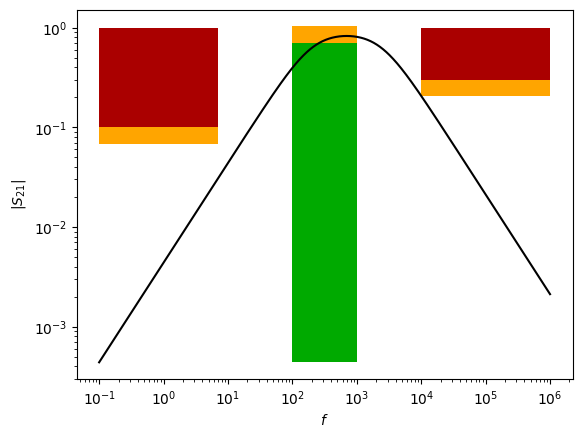

-0.08039616428633192

In [21]:
spec.cost(plot=True, par1C=math.log(3e-6), ser1C=math.log(7e-6))

In [22]:
pbounds = {'par1C': (math.log(1e-7), math.log(1e-2)), 'ser1C': (math.log(1e-7), math.log(1e-2))}

optimizer = BayesianOptimization(
    f=spec.cost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=4,
    n_iter=10,
)

print(optimizer.max)

|   iter    |  target   |   par1C   |   ser1C   |
-------------------------------------------------
| 1         | -0.4792   | -11.32    | -7.825    |
| 2         | -0.4844   | -16.12    | -12.64    |
| 3         | -0.6785   | -14.43    | -15.06    |
| 4         | -0.1549   | -13.97    | -12.14    |
| 5         | -0.2314   | -14.87    | -11.87    |
| 6         | -0.04834  | -13.54    | -10.76    |
| 7         | -0.1832   | -11.02    | -11.86    |
| 8         | -1.597    | -5.537    | -13.95    |
| 9         | -1.325    | -16.12    | -4.605    |
| 10        | -1.938    | -4.605    | -4.605    |
| 11        | -0.04505  | -12.07    | -10.52    |
| 12        | -0.04307  | -12.59    | -11.27    |
| 13        | -0.059    | -12.92    | -10.03    |
| 14        | -0.0259   | -12.81    | -10.73    |
{'target': -0.02589939786005873, 'params': {'par1C': -12.805451611658807, 'ser1C': -10.726619785041901}}


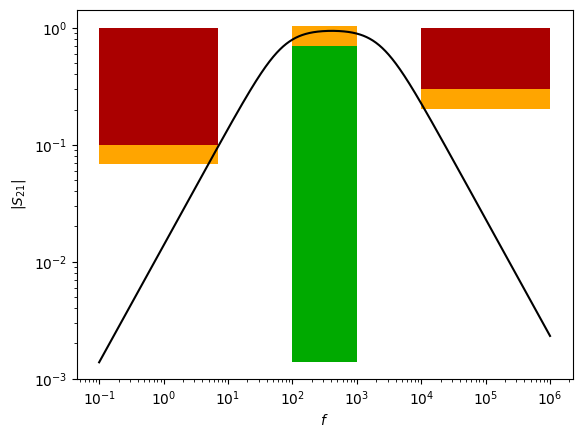

-0.02589939786005873

In [23]:
spec.cost(plot=True, par1C=optimizer.max['params']['par1C'], ser1C=optimizer.max['params']['ser1C'])

In [24]:
import math
math.log(1+1)

0.6931471805599453